In [15]:
# import pandas as pd

In [16]:
# df = pd.read_csv('RegresiUTSTelkom (1).csv')

In [17]:
# # prompt: buatkan kodingan untuk menghapus 3/4 data entry pada dataset lalu di download

# # Calculate the number of rows to keep (1/4 of the original dataset)
# rows_to_keep = int(len(df) * 0.25)

# # Randomly sample the rows to keep
# df_subset = df.sample(n=rows_to_keep, random_state=42) # Using random_state for reproducibility

# # Save the subset DataFrame to a new CSV file
# subset_filename = 'subset_RegresiUTSTelkom.csv'
# df_subset.to_csv(subset_filename, index=False)

# # Download the new CSV file
# from google.colab import files
# files.download(subset_filename)

# print(f"Original dataset had {len(df)} rows.")
# print(f"Subset dataset has {len(df_subset)} rows (approximately 1/4).")
# print(f"Subset data saved to '{subset_filename}' and is ready for download.")


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('RegresiUTSTelkom (1).csv')

# Target column adalah kolom pertama, fitur adalah kolom selain itu
X = data.iloc[:, 1:]  # Semua kolom kecuali kolom pertama (target)
y = data.iloc[:, 0]   # Kolom pertama adalah target


In [19]:
# prompt: buatkan kodingan untuk menghapus duplikat

# Identifikasi dan hapus duplikat
print("Jumlah baris sebelum menghapus duplikat:", len(data))
data_cleaned = data.drop_duplicates()
print("Jumlah baris setelah menghapus duplikat:", len(data_cleaned))

# Perbarui X dan y setelah menghapus duplikat (opsional, tergantung kebutuhan)
# X = data_cleaned.iloc[:, 1:]
# y = data_cleaned.iloc[:, 0]

Jumlah baris sebelum menghapus duplikat: 515344
Jumlah baris setelah menghapus duplikat: 515130


In [20]:
# prompt: buatkan kodingan untuk menghapus semua outliers

import numpy as np

# Assuming 'data_cleaned' is your DataFrame after removing duplicates
# We will use the Interquartile Range (IQR) method to detect and remove outliers

# Select numerical columns to check for outliers
# Adjust this based on your actual numerical columns
numerical_cols = data_cleaned.select_dtypes(include=np.number).columns

print("\nJumlah baris sebelum menghapus outliers:", len(data_cleaned))

# Iterate through numerical columns and remove outliers
for col in numerical_cols:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers for the current column
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower_bound) & (data_cleaned[col] <= upper_bound)]

print("Jumlah baris setelah menghapus outliers:", len(data_cleaned))

# Now, update X and y with the data after removing outliers
X = data_cleaned.iloc[:, 1:]  # Assuming target is still the first column
y = data_cleaned.iloc[:, 0]   # Assuming target is still the first column

print("\nX shape after outlier removal:", X.shape)
print("y shape after outlier removal:", y.shape)



Jumlah baris sebelum menghapus outliers: 515130
Jumlah baris setelah menghapus outliers: 37269

X shape after outlier removal: (37269, 90)
y shape after outlier removal: (37269,)


In [21]:
# Menghapus missing values (jika ada)
X = X.dropna()
y = y[X.index]

# Split data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Mengonversi data ke tensor PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Membuat DataLoader untuk batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Definisikan model MLP
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Inisialisasi model, loss function, dan optimizer
model = MLPModel(X_train_scaled.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Fungsi pelatihan untuk model
def train_model(model, train_loader, loss_fn, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {running_loss/len(train_loader)}")

    return model

# Latih model
model_trained = train_model(model, train_loader, loss_fn, optimizer)


Epoch [0/100], Loss: 3793860.495439914
Epoch [10/100], Loss: 24752.243268843886
Epoch [20/100], Loss: 21377.305628960738
Epoch [30/100], Loss: 19486.104822772766
Epoch [40/100], Loss: 17930.9588025793
Epoch [50/100], Loss: 16531.255981445312
Epoch [60/100], Loss: 16122.157732656586
Epoch [70/100], Loss: 15795.899958925698
Epoch [80/100], Loss: 15445.811857166209
Epoch [90/100], Loss: 15294.876654498055


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluasi model
model_trained.eval()
with torch.no_grad():
    y_pred_train = model_trained(X_train_tensor)
    y_pred_test = model_trained(X_test_tensor)

# Menghitung MSE, RMSE, dan R^2 untuk evaluasi
y_pred_test_np = y_pred_test.numpy()
y_pred_train_np = y_pred_train.numpy()

# MSE, RMSE, dan R^2 untuk set test
mse_test = mean_squared_error(y_test_tensor.numpy(), y_pred_test_np)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_tensor.numpy(), y_pred_test_np)

print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {r2_test}")


MSE: 172.83407592773438
RMSE: 13.146637438057473
R^2: -1.7708330154418945


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Build the MLP model using TensorFlow
def create_mlp_model(input_dim):
    model = models.Sequential()

    # Input Layer
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Hidden Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    # Output Layer (regression task, so no activation function)
    model.add(layers.Dense(1))

    # Compile the model with an Adam optimizer and learning rate scheduling
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

    return model

# Create the model
model = create_mlp_model(X_train_scaled.shape[1])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


932/932 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3946117.5000 - val_loss: 3498201.0000
Epoch 2/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3230894.2500 - val_loss: 2333255.2500
Epoch 3/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2026721.1250 - val_loss: 1158875.1250
Epoch 4/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 936814.6875 - val_loss: 378284.0625
Epoch 5/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 279781.5000 - val_loss: 60337.4570
Epoch 6/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 49603.2070 - val_loss: 3108.6650
Epoch 7/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16830.6719 - val_loss: 305.2279
Epoch 8/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 15941.3047 - val_loss: 248.1553
Epoch 9/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15953.5361 - val_loss: 221.0009
Epoch 10/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 16129.2197 - val_loss: 231.8317
Epoch 11/100
932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step -

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prediksi untuk data uji
y_pred_test = model.predict(X_test_scaled)

# Menghitung MSE, RMSE, dan R^2 untuk evaluasi
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {r2_test}")


233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 60.52359390258789
RMSE: 7.779691118713383
R^2: 0.029700756072998047


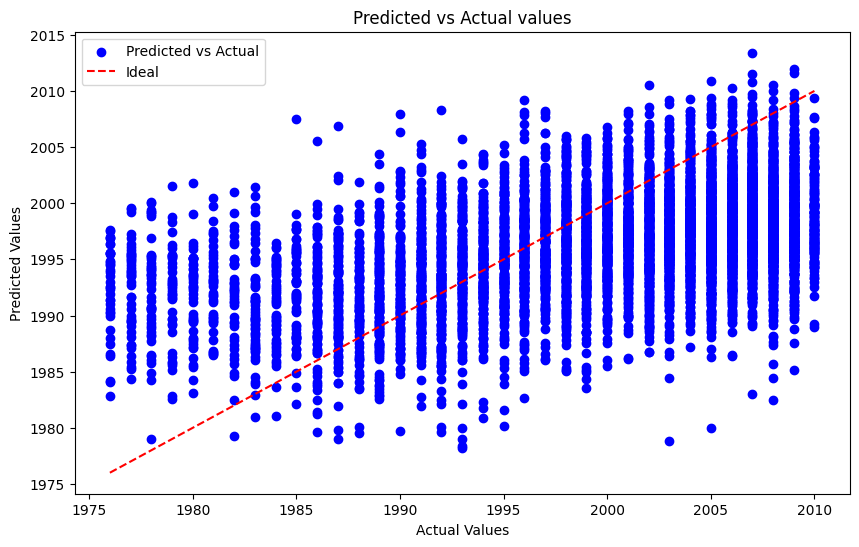

In [27]:
import matplotlib.pyplot as plt

# Visualisasi Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual values')
plt.legend()
plt.show()
